In [1]:
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import os
%run helpers_preproc.ipynb
%matplotlib widget

# Hyper Parameters

In [2]:
origDataDir = 'SHREC11/'
newDataDir = 'SHREC11_plus/'
K = 5
radiuss = [0.0002,0.0004,0.0008]
train_size = 450 * len(radiuss)
test_size = (600-450) * len(radiuss)

# 1. expand dataset and scramble

In [3]:
expand(origDataDir, newDataDir, radiuss)
scramble(newDataDir, 10000,600 * len(radiuss))

# 2. read in the dataset

## 2.1 read in v (252 x 3),f (...x...) and cluster

In [4]:
ver_list = []
adj_list = []
Nadj_list = []
gMat_list = []
gLbl_list = []

for i in range(600 * len(radiuss)):
    v, f = get_nodes(newDataDir + 'T' + str(i) + '.obj')
    group_mat, group_labels = K_mean_cluster(v, K)
    
    adj = get_adj_from_f(f)            
    normed_adj = adj / np.reshape(np.sum(adj,axis = 0),[252,1])
    ver_list.append(v)
    adj_list.append(adj)
    Nadj_list.append(normed_adj)
    gMat_list.append(group_mat)
    gLbl_list.append(group_labels)
    
    
vers = np.array(ver_list)
adjs = np.array(adj_list)
Nadjs = np.array(Nadj_list)
gMats = np.array(gMat_list)
gLbls = np.array(gLbl_list)

/Users/davidsoncheng/.conda/envs/TSP/lib/python3.10/site-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_7342/2399023897.py:12: RuntimeWarning: invalid value encountered in true_divide
  normed_adj = adj / np.reshape(np.sum(adj,axis = 0),[252,1])


## 2.2 Read in the labels

In [5]:
label_np = np.array(readLbl(600 * len(radiuss),newDataDir+'labels.txt'))
label_np_train = label_np[:train_size]
label_np_test = label_np[train_size:]

## 2.3 Split into training set and testing set

In [86]:
vers_train = torch.tensor(vers[:train_size]).float()
adjs_train = torch.tensor(adjs[:train_size]).float()
nadjs_train = torch.nan_to_num(torch.tensor(Nadjs[:train_size]).float(),0,0,0)
gMats_train = torch.tensor(gMats[:train_size]).float()
label_train = torch.tensor(label_np_train).float()

vers_test = torch.tensor(vers[train_size:]).float()
adjs_test = torch.tensor(adjs[train_size:]).float()
nadjs_test = torch.nan_to_num(torch.tensor(Nadjs[train_size:]).float(),0,0,0)
gMats_test = torch.tensor(gMats[train_size:]).float()
label_test = torch.tensor(label_np_test).float()

label_mat_train = torch.tensor(np.where(igl.all_pairs_distances(label_np_train,label_np_train,False) > 0.5,0,1)).float()
label_mat_test = torch.tensor(np.where(igl.all_pairs_distances(label_np_test,label_np_test,False) > 0.5,0,1)).float()

In [7]:
#detect_nan(label_mat_train)

In [8]:
#label_mat_train

In [9]:
#print message about training and testing dataset
# print(vers_train.shape)
# print(adjs_train.shape)
# print(nadjs_train.shape)
# print(gMats_train.shape)

# 3. Training

## 3.1 Hyperparameters for training

In [92]:
contraGWs = [20,20,20,20]
contraMWs = [20,20,20,20]
atkGWs = [20,20,20,20]
atkMWs = [20,20,20,K * 3 + 1]

## 3.2 Initialize neural networks

In [93]:
%run NNs.ipynb
%run helpers_preproc.ipynb
contraG = GCN(3,contraGWs)
contraM = MLP(252* contraGWs[len(contraGWs)-1],contraMWs)
atkG = GCN(3,atkGWs)
atkM = MLP_atk(252* atkGWs[len(contraGWs)-1], 1, K, atkMWs)

## 3.4 Extract node-level features from clean data

In [94]:
feas_clean = extract_node_feature(vers_train,adjs_train)

In [95]:
%run L.ipynb

## 3.5 Feed clean data into contraNN🤠

## 3.6 Train atkNN😈 with contraNN🤠

In [96]:
atkLR = 0.0001
contraLR = 0.0001

In [ ]:
feas_clean = extract_node_feature(vers_train,adjs_train)

for contraI in range(100):
    optAtk = optim.Adam(atkG.weights + atkM.weights,lr = atkLR)
    
    print("\t loss \t\t same mean \t diff mean \t same std")

    for atkI in range(10):
        optAtk.zero_grad()
        atkOut = atkM.forward(atkG.forward(nadjs_train,feas_clean))
        poisonedVers = translate_by_group(vers_train,gMats_train,atkOut)

        feas_poisoned = extract_node_feature(poisonedVers,adjs_train)

        contraOutPoisoned = contraM.forward(contraG.forward(nadjs_train,feas_poisoned))
        contraLossPoisoned = lossAtkF(contraOutPoisoned,label_mat_train)

        contraLossPoisoned.backward()
        optAtk.step()
        
    optContra = optim.Adam(contraG.weights + contraM.weights,lr = contraLR)
    print("\t loss \t\t same mean \t diff mean \t same std")
        
    for contraI in range(10):
        optContra.zero_grad()
        
#         atkOutFlat1 = atkM.forward(atkG.forward(nadjs_train,feas_clean)) * max_poison
#         atkOut1 = torch.reshape(atkOutFlat1,[train_size,K,3])
        atkOut1 = atkM.forward(atkG.forward(nadjs_train,feas_clean))
        poisonedVers1 = translate_by_group(vers_train,gMats_train,atkOut1)
        
        feas_poisoned1 = extract_node_feature(poisonedVers1,adjs_train)
        
        contraOutPoisoned1 = contraM.forward(contraG.forward(nadjs_train,feas_poisoned1))
        contraLossPoisoned1 = lossContraF(contraOutPoisoned1,label_mat_train)
    
        contraLossPoisoned1.backward()
        optContra.step()

	 loss 		 same mean 	 diff mean 	 same std
A:😈 	 -0.00739 	 0.08776 	 0.10007 	 0.49183
A:😈 	 -0.00734 	 0.08796 	 0.10023 	 0.49287
A:😈 	 -0.00731 	 0.08817 	 0.10042 	 0.49396
A:😈 	 -0.00728 	 0.08831 	 0.10053 	 0.49464
A:😈 	 -0.00725 	 0.08843 	 0.10063 	 0.49528
A:😈 	 -0.00721 	 0.08855 	 0.10072 	 0.49591
A:😈 	 -0.00718 	 0.08865 	 0.10079 	 0.49639
A:😈 	 -0.00715 	 0.08866 	 0.10078 	 0.49649
A:😈 	 -0.00712 	 0.08866 	 0.10075 	 0.49646
A:😈 	 -0.00709 	 0.08865 	 0.10071 	 0.49643
	 loss 		 same mean 	 diff mean 	 same std
C:🤠 	 -0.00706 	 0.08864 	 0.10066 	 0.49633
C:🤠 	 -0.00933 	 0.11439 	 0.13012 	 0.63961
C:🤠 	 -0.01049 	 0.12228 	 0.13965 	 0.68736
C:🤠 	 -0.01103 	 0.12549 	 0.14362 	 0.70953
C:🤠 	 -0.01164 	 0.13635 	 0.15569 	 0.77059
C:🤠 	 -0.01236 	 0.15221 	 0.17314 	 0.85697
C:🤠 	 -0.0134 	 0.16885 	 0.19172 	 0.9476
C:🤠 	 -0.01462 	 0.18122 	 0.206 	 1.01629
C:🤠 	 -0.01551 	 0.18267 	 0.20846 	 1.02801
C:🤠 	 -0.0157 	 0.17536 	 0.20099 	 0.99338
	 loss 		 same mean

A:😈 	 -0.09192 	 0.50615 	 0.62572 	 2.76469
A:😈 	 -0.09164 	 0.50746 	 0.62682 	 2.77179
A:😈 	 -0.09114 	 0.50859 	 0.62752 	 2.77797
A:😈 	 -0.09071 	 0.509 	 0.62751 	 2.78019
A:😈 	 -0.09042 	 0.50897 	 0.62719 	 2.78003
A:😈 	 -0.09016 	 0.5096 	 0.6276 	 2.78344
	 loss 		 same mean 	 diff mean 	 same std
C:🤠 	 -0.08989 	 0.51101 	 0.62881 	 2.79113
C:🤠 	 -0.07768 	 0.47236 	 0.57585 	 2.58079
C:🤠 	 -0.08573 	 0.49321 	 0.60588 	 2.69405
C:🤠 	 -0.08629 	 0.49013 	 0.60319 	 2.67726
C:🤠 	 -0.0939 	 0.52686 	 0.64954 	 2.87797
C:🤠 	 -0.09334 	 0.5353 	 0.65789 	 2.92465
C:🤠 	 -0.09421 	 0.53761 	 0.66118 	 2.93702


## 3.7 Seeing how it does on Test Data

In [87]:
feas_clean_test = extract_node_feature(vers_test,adjs_test)

atkTest = atkM.forward(atkG.forward(nadjs_test,feas_clean_test))
print(atkTest.shape)
print(vers_test.shape)
print(gMats_test.shape)

poisonedVersTest = translate_by_group(vers_test,gMats_test,atkTest)
        
feas_poisoned_test = extract_node_feature(poisonedVersTest,adjs_test)
        
contraOutPoisonedTest = contraM.forward(contraG.forward(nadjs_test,feas_poisoned_test))
contraLossPoisonedTest = lossContraF(contraOutPoisonedTest,label_mat_test)

contraOutCleanTest = contraM.forward(contraG.forward(nadjs_test,feas_clean_test))
contraLossCleanTest = lossContraF(contraOutCleanTest,label_mat_test)

torch.Size([450, 5, 3])
torch.Size([450, 252, 3])
torch.Size([450, 252, 5])
C:🤠 	 -0.15567 	 1.09101 	 1.30633 	 5.96409
C:🤠 	 -0.09521 	 0.27421 	 0.38457 	 1.51418


In [24]:
plt.clf()

(1350, 252, 3)


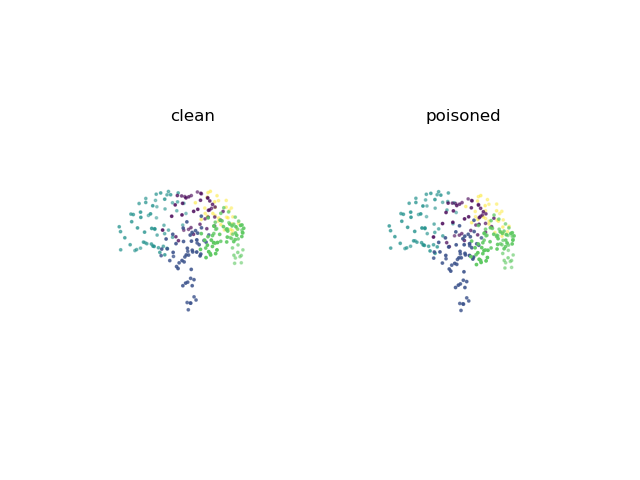

In [91]:
from mpl_toolkits.mplot3d import axes3d


index_in_question = 5

#Plot first clustered mesh
dataPlot = vers[index_in_question]

fig = plt.figure()
ax = fig.add_subplot(121,projection='3d')

ax.scatter(dataPlot[:,0], dataPlot[:,1], dataPlot[:,2], label=gLbls[index_in_question,:], c = gLbls[index_in_question,:], cmap = 'viridis',s = 3)
ax.set_title('clean')

plt.axis('off')

#Plot second clustered point coud
#get poison
atkOut = atkM.forward(atkG.forward(nadjs_train,feas_clean))
poisonedVers = translate_by_group(vers_train,gMats_train,atkOut).detach().numpy()

print(poisonedVers.shape)
#poisioedVers = np.zeros([1350,252,3])
poisonedDataPlot = vers[index_in_question] + poisonedVers[index_in_question]

ax = fig.add_subplot(122,projection='3d')

ax.scatter(poisonedDataPlot[:,0], poisonedDataPlot[:,1], poisonedDataPlot[:,2], label=gLbls[index_in_question,:], c = gLbls[index_in_question,:], cmap = 'viridis', s = 3)
ax.set_title('poisoned')

plt.axis('off')

plt.show()

In [ ]:
# ax.axes.xaxis.set_ticklabels([])
# ax.axes.yaxis.set_ticklabels([])
# ax.axes.zaxis.set_ticklabels([])
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')